In [65]:
import igraph as ig
import geopandas as gpd
import itertools as it

import numpy as np
from matplotlib import pyplot as plt

# Graph

In [66]:
g = ig.Graph(directed=True)

In [67]:
V_O = {f'RC{i+1}':i for i in range(4)}
V_O_attr = {
    'name': [e for e in V_O.keys()],
    'x': [0,3,3,0],
    'y': [0,0,3,3],
    'color': ['red','red','red','red'],
    'type': 'res_node',
}
g.add_vertices(V_O.values(), V_O_attr)

In [68]:
V_P = {f'PT{i+1}':e for i,e in enumerate(range(4,8))}
V_P_attr = {
    'name': [e for e in V_P.keys()],
    'x': [0.2,2.8,2.8,0.2],
    'y': [0.2,0.2,2.8,2.8],
    'color': 'blue',
    'type': 'pt_node',
}
g.add_vertices(V_P.values(), V_P_attr)

In [69]:
V_D = {f'POI{i+1}':e for i,e in enumerate(range(8,12))}
V_D_attr = {
    'name': [e for e in V_D.keys()],
    'x': [0.3,2.7,2.7,0.3],
    'y': [0.3,0.3,2.7,2.7],
    'color': 'green',
    'type': 'poi_node',
}
g.add_vertices(V_D.values(), V_D_attr)

## PTN Edges

In [70]:
# Speeds
WALKING_SPEED = 5  # units per hour
BUS_SPEED = 100  # units per hour
TRAIN_SPEED = 1000  # units per hour

In [71]:
def compute_dist_from_es(es: list):
    positions = [(g.vs[e[0]]['x'], g.vs[e[0]]['y'], g.vs[e[1]]['x'], g.vs[e[1]]['y']) for e in es]
    pos_arr = np.array(positions)
    return np.sqrt((pos_arr[:,[0,2]].max(axis=1)-pos_arr[:,[0,2]].min(axis=1))**2+
                   (pos_arr[:,[1,3]].max(axis=1)-pos_arr[:,[1,3]].min(axis=1))**2)

### Walking

In [72]:
E_WALK = list(it.product(V_O.values(),V_P.values())) +\
         list(it.product(V_P.values(), V_D.values())) +\
         list(it.product(V_O.values(), V_D.values()))
distances_walk = compute_dist_from_es(E_WALK)
E_WALK_attr = {
    'distance': distances_walk,
    'tt': (distances_walk * 1/WALKING_SPEED) * 60,
    'weight': (distances_walk * 1/WALKING_SPEED) * 60,
    'color': 'gray',
    'type': 'walk',
}
g.add_edges(E_WALK, E_WALK_attr)

### PT

In [73]:
E_TRAIN = [
    (V_P['PT1'],V_P['PT2']),  # Train_line_1
    (V_P['PT2'],V_P['PT3']),  # Train_line_1
    (V_P['PT4'],V_P['PT3']),  # Train_line_2,
    (V_P['PT4'],V_P['PT1']),  # Train_line_2
]
distances_train = compute_dist_from_es(E_TRAIN)
E_TRAIN_attr = {
    'name': list(it.repeat('Train_line_1',2)).extend(it.repeat('Train_line_2',2)),
    'distance': distances_train,
    'tt': (distances_train * 1/TRAIN_SPEED) * 60,
    'weight': (distances_train * 1/TRAIN_SPEED) * 60,
    'color': 'orange',
    'type': 'train'
}
g.add_edges(E_TRAIN, E_TRAIN_attr)

In [74]:
distances_train

array([2.6, 2.6, 2.6, 2.6])

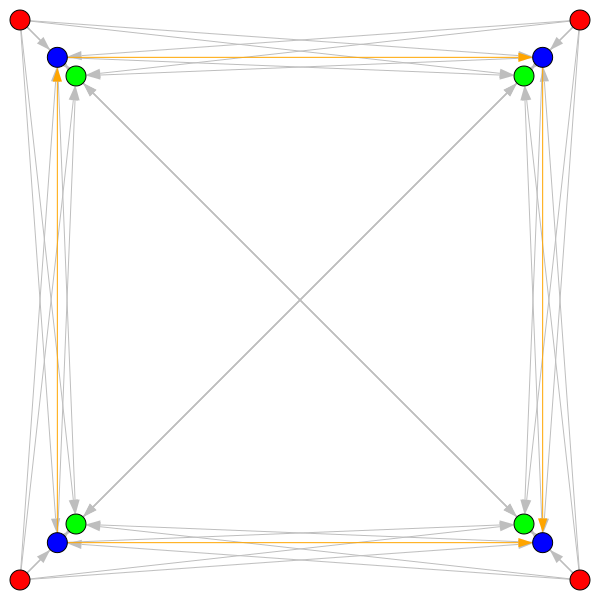

In [75]:
# fig, ax = plt.subplots(figsize=(5,5))
ig.plot(g, target='plots/synthetic_graphs/synthetic_graph_2.svg')

In [76]:
g.es['active'] = 1

In [77]:
# g.save('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/graph.gml')
# g.save('/home/rico/Documents/thesis/experiments/base_data/graph_1.gml')

# Census Data

In [78]:
data = {
    'neighborhood': V_O_attr['name'],
    'n_inh': [1000,1000,1000,1000],
    'n_purple': [500, 500, 500, 500],
    'n_red':    [500, 500, 500, 500],
    'res_centroids': gpd.points_from_xy(V_O_attr['x'], V_O_attr['y'])
}

gdf = gpd.GeoDataFrame(data, geometry='res_centroids')
gdf

,neighborhood,n_inh,n_purple,n_red,res_centroids
0,RC1,1000,500,500,POINT (0.00000 0.00000)
1,RC2,1000,500,500,POINT (3.00000 0.00000)
2,RC3,1000,500,500,POINT (3.00000 3.00000)
3,RC4,1000,500,500,POINT (0.00000 3.00000)


In [79]:
# gdf.to_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_1/census_data.geojson', driver='GeoJSON')
# gdf.to_file('/home/rico/Documents/thesis/experiments/base_data/census_data_1.geojson', driver='GeoJSON')

# Reward Computation

In [80]:
from ptnrue.rewards.egalitarian import EgalitarianTheilReward
import itertools as it

In [81]:
census_data = gdf.copy()
census_data['geometry'] = census_data['res_centroids']
r = EgalitarianTheilReward(census_data=census_data, com_threshold=15)

In [82]:
r.evaluate(g)

25.79188454310778

In [83]:
g_prime = g.copy()

rewards = {}

n_edges = 3
possible_edges = it.combinations(g_prime.es.select(type_ne='walk', active_eq=1), n_edges)

for es in possible_edges:
    g_prime = g.copy()
    pseudo_index = '|'.join([f"{e.source_vertex['name']}->{e.target_vertex['name']}" for e in es])
    print(pseudo_index)
    for e in es:
        g_prime.es[e.index]['active'] = 0
    rewards[pseudo_index] = r.evaluate(g_prime)

PT1->PT2|PT2->PT3|PT4->PT3
PT1->PT2|PT2->PT3|PT4->PT1
PT1->PT2|PT4->PT3|PT4->PT1
PT2->PT3|PT4->PT3|PT4->PT1


In [84]:
rewards

{'PT1->PT2|PT2->PT3|PT4->PT3': 60.86631703291793,
 'PT1->PT2|PT2->PT3|PT4->PT1': 56.53836946015945,
 'PT1->PT2|PT4->PT3|PT4->PT1': 56.53836946015795,
 'PT2->PT3|PT4->PT3|PT4->PT1': 56.53836946015721}

In [85]:
r.evaluate(g)

25.79188454310778

In [88]:
g_prime = g.copy()

rewards = {}

n_edges = 3
possible_edges = it.combinations(g_prime.es.select(type_ne='walk', active_eq=1), n_edges)

for es in possible_edges:
    g_prime = g.copy()
    pseudo_index = '|'.join([f"{e.source_vertex['name']}->{e.target_vertex['name']}" for e in es])
    print(pseudo_index)
    for e in es:
        g_prime.es[e.index]['active'] = 0
    rewards[pseudo_index] = r.evaluate(g_prime)

PT1->PT2|PT2->PT3|PT4->PT3
PT1->PT2|PT2->PT3|PT4->PT1
PT1->PT2|PT4->PT3|PT4->PT1
PT2->PT3|PT4->PT3|PT4->PT1


In [89]:
rewards

{'PT1->PT2|PT2->PT3|PT4->PT3': 60.86631703291793,
 'PT1->PT2|PT2->PT3|PT4->PT1': 56.53836946015945,
 'PT1->PT2|PT4->PT3|PT4->PT1': 56.53836946015795,
 'PT2->PT3|PT4->PT3|PT4->PT1': 56.53836946015721}